#### Importação das bibliotecas

In [254]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

#### Carregamento e ajuste dos dados

In [255]:
data = pd.read_csv('./data/BTC-USD.csv')
data = data.iloc[2:,:]
data.head(10)

,Price,Close,High,Low,Open,Volume
2,2014-09-17,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
3,2014-09-18,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
4,2014-09-19,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700
5,2014-09-20,408.90399169921875,423.2959899902344,389.88299560546875,394.6730041503906,36863600
6,2014-09-21,398.8210144042969,412.4259948730469,393.1809997558594,408.0849914550781,26580100
7,2014-09-22,402.1520080566406,406.9159851074219,397.1300048828125,399.1000061035156,24127600
8,2014-09-23,435.7909851074219,441.5570068359375,396.1969909667969,402.0920104980469,45099500
9,2014-09-24,423.2049865722656,436.11199951171875,421.1319885253906,435.7510070800781,30627700
10,2014-09-25,411.5740051269531,423.5199890136719,409.4679870605469,423.156005859375,26814400
11,2014-09-26,404.42498779296875,414.93798828125,400.0090026855469,411.4289855957031,21460800


In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 2 to 4019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   4018 non-null   object
 1   Close   4018 non-null   object
 2   High    4018 non-null   object
 3   Low     4018 non-null   object
 4   Open    4018 non-null   object
 5   Volume  4018 non-null   object
dtypes: object(6)
memory usage: 188.5+ KB


Aqui notamos que estao todas as colunas com o tipo incorreto, vamos ajustar cada uma delas

In [257]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

Apliquei a função pd.to_numeric em cada uma dessas colunas que converte os valores pra número (float ou int)<br>
Se algum valor não puder ser convertido (por exemplo, "ABC", "?", "-"), o parâmetro errors='coerce' manda ele transformar em NaN (valor nulo)

In [258]:
data.dtypes

Price      object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

agora so falta colocar a coluna de data, para o tipo data

In [259]:
data = data.rename(columns={'Price': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [260]:
data = data.set_index('Date')
data = data.sort_index()

Agora já ajustei o nome da coluna, transformei para data, coloquei a data como indice do meu dataset e ordenei por garantia, porque vi que a ordem era importante para uma LSTM

In [261]:
data.head(15)

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600
2014-09-23,435.790985,441.557007,396.196991,402.092010,45099500
2014-09-24,423.204987,436.112000,421.131989,435.751007,30627700
2014-09-25,411.574005,423.519989,409.467987,423.156006,26814400


In [262]:
data.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [263]:
data[data.duplicated() == True]

,Close,High,Low,Open,Volume
Date,,,,,


#### Explorando um pouco os dados

In [264]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,4018.0,2.487618e+04,2.954574e+04,1.781030e+02,2.506395e+03,1.029073e+04,3.932764e+04,1.233441e+05
High,4018.0,2.536239e+04,3.004142e+04,2.117310e+02,2.571953e+03,1.046631e+04,4.023595e+04,1.244571e+05
Low,4018.0,2.431383e+04,2.897382e+04,1.715100e+02,2.387572e+03,1.002435e+04,3.811345e+04,1.189592e+05
Open,4018.0,2.484895e+04,2.951551e+04,1.768970e+02,2.494930e+03,1.028126e+04,3.930022e+04,1.233394e+05
Volume,4018.0,2.058300e+10,2.186031e+10,5.914570e+06,1.083760e+09,1.650599e+10,3.213259e+10,3.509679e+11


In [265]:
data.median().to_frame(name='median')

,median
Close,1.029073e+04
High,1.046631e+04
Low,1.002435e+04
Open,1.028126e+04
Volume,1.650599e+10


In [266]:
data.var().to_frame(name='var')

,var
Close,8.729507e+08
High,9.024867e+08
Low,8.394820e+08
Open,8.711655e+08
Volume,4.778730e+20


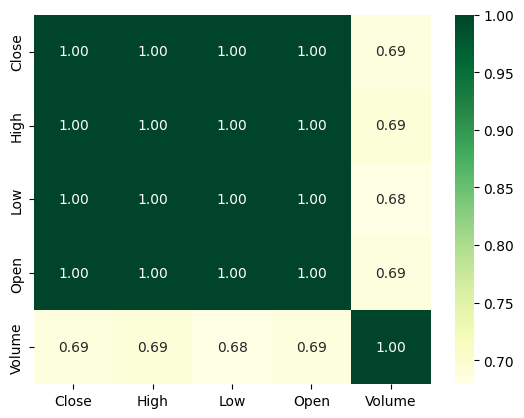

In [267]:
plt.Figure()
sns.heatmap(data.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

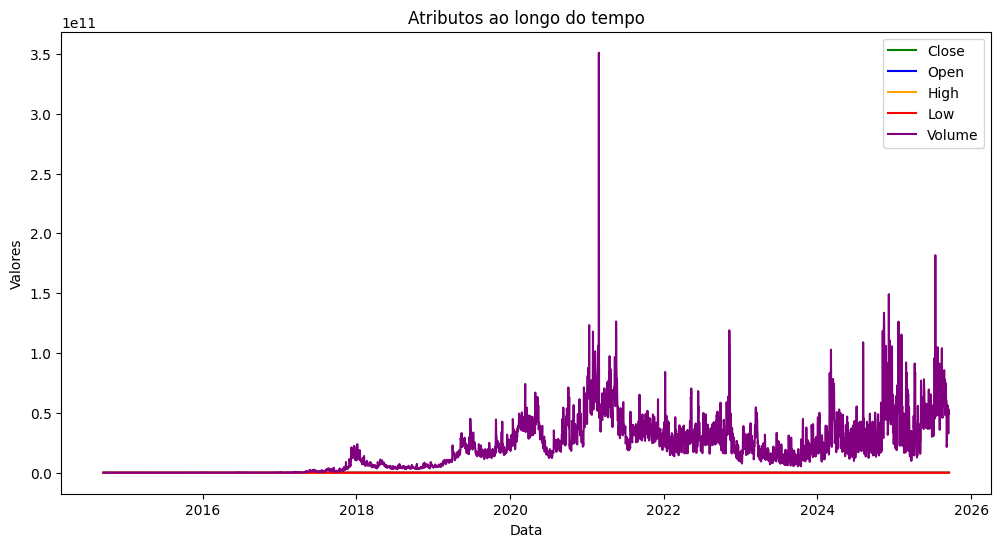

In [268]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Close', color='green')
plt.plot(data.index, data['Open'], label='Open', color='blue')
plt.plot(data.index, data['High'], label='High', color='orange')
plt.plot(data.index, data['Low'], label='Low', color='red')
plt.plot(data.index, data['Volume'], label='Volume', color='purple')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

Aqui nao conseguimos visualizar bem porque o valor do volume é bem superior aos demais, para melhor visualização vou normalizar os dados

In [269]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
data_scaled = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

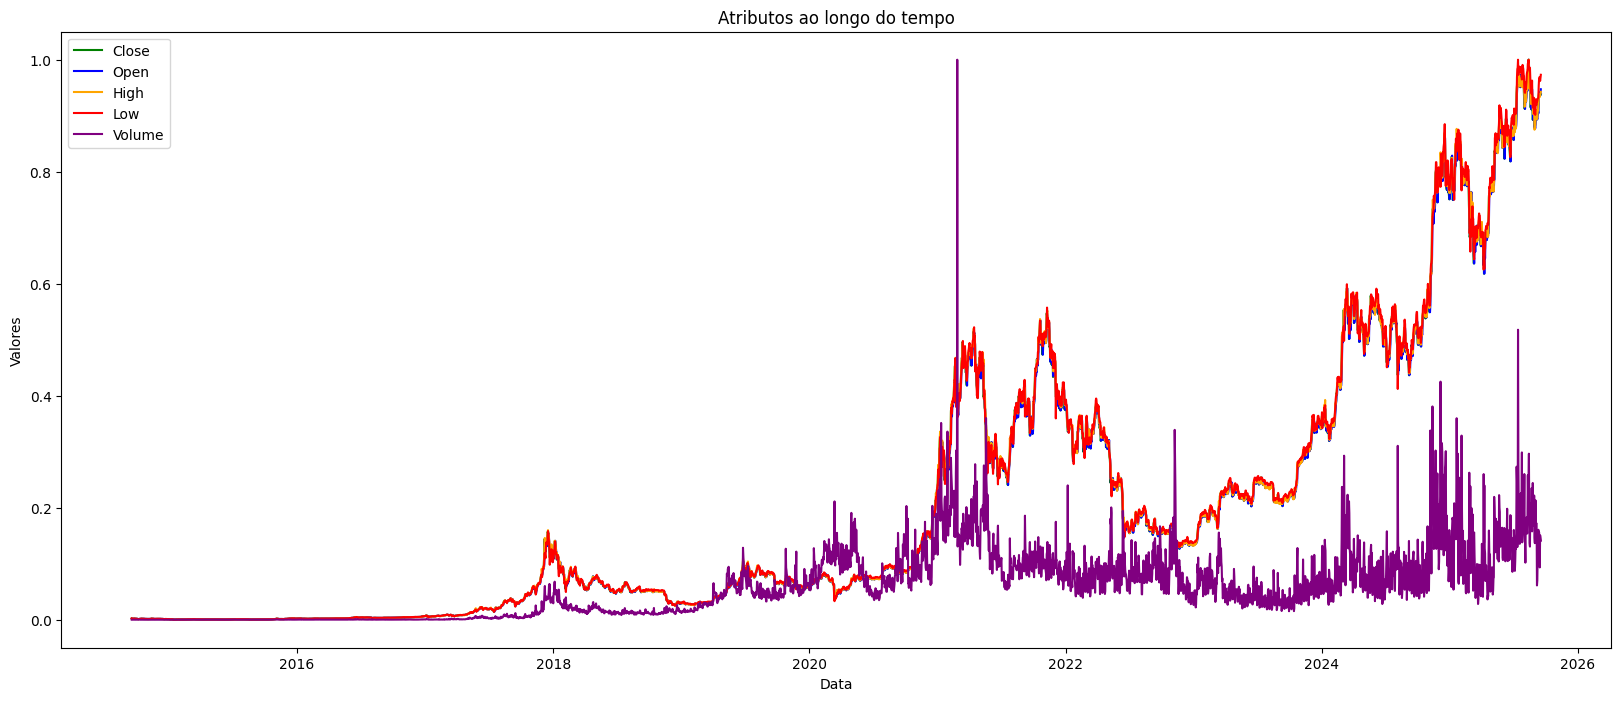

In [270]:
plt.figure(figsize=(20,8))

plt.plot(data_scaled.index, data_scaled['Close'], label='Close', color='green')
plt.plot(data_scaled.index, data_scaled['Open'], label='Open', color='blue')
plt.plot(data_scaled.index, data_scaled['High'], label='High', color='orange')
plt.plot(data_scaled.index, data_scaled['Low'], label='Low', color='red')
plt.plot(data_scaled.index, data_scaled['Volume'], label='Volume', color='purple')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

podemos notar que close, open, high e low possuem praticamente a mesma tendencia como acusado pela matriz de correlação, já o volume tem o comportamento diferente, com picos e quedas meio bruscas

#### Aplicação de Modelo para predição

##### OBJETIVOS

- [X] Tirar normalização do conjunto de teste (Não funcionou)
- [X] Adicionar metricas de erro e por em porcentagem
- [X] Adicionar metricas de acertividade
- [X] Normalizar o conjunto corretamente
- [ ] Mudar arquitetura do meu modelo - **FAZER**
- [ ] Fazer o modelo treinar com outros parametros e retornar o melhor - Grid Search?
- [ ] Avaliar com o conjunto normalizado e não normalizado
- [ ] Fazer o modelo treinar com janelas de tempo diferentes e retornar o melhor
- [ ] Fazer treinamento+validação com e sem o early stopping e analisar o melhor
- [ ] Fazer um modelo com multiplas features? 

In [271]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)


In [272]:
serie = data['Close']

train_size = int(0.7 * len(serie))

train_data = serie[:train_size].values.reshape(-1, 1)
test_data = serie[train_size:].values.reshape(-1, 1)

# print(test_data)

scaler = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler.fit_transform(train_data)
data_test_scaled = scaler.transform(test_data)


In [273]:
# O que está acontecendo é que minmax quer um array 2d, preciso ajustar isso no x,y train e teste

SEQ_LEN = 14

X_train_scaled, y_train_scaled = create_sequences(data_train_scaled, SEQ_LEN)
X_test_scaled, y_test_scaled = create_sequences(data_test_scaled, SEQ_LEN)


In [274]:

model = Sequential([
    LSTM(100, input_shape=(SEQ_LEN, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=90,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/100


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0070 - mae: 0.0430 - val_loss: 0.0053 - val_mae: 0.0553
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0171 - mae: 0.0845 - val_loss: 0.0059 - val_mae: 0.0653
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0304 - mae: 0.1123 - val_loss: 0.2182 - val_mae: 0.4526
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0184 - mae: 0.0988 - val_loss: 0.0818 - val_mae: 0.2752
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0460 - val_loss: 0.0024 - val_mae: 0.0383
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - mae: 0.0184 - val_loss: 0.0023 - val_mae: 0.0387
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0023 - val_mae: 0.0380
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - mae: 0.0205 - val_loss: 0.0023 - val_mae: 0.0378
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 -

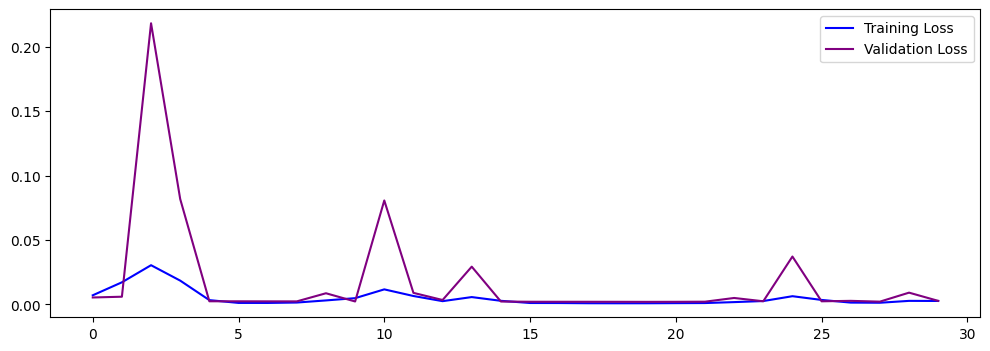

In [275]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label="Training Loss", color='blue') 
plt.plot(history.history['val_loss'], label="Validation Loss", color='purple')
plt.legend()
plt.show()

In [276]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test = scaler.inverse_transform(y_test_scaled)

# print(y_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

mae_percent = (mae / np.mean(y_test)) * 100
rmse_percent = (rmse / np.mean(y_test)) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE(%): {mae_percent:.2f}%")
print(f"RMSE(%): {rmse_percent:.2f}%")
print(f"MAPE(%): {mape:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 4320.820089660235
RMSE: 6816.96932171683
MAE(%): 7.92%
RMSE(%): 12.50%
MAPE(%): 6.10%


In [277]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.2f}")


R²: 0.96


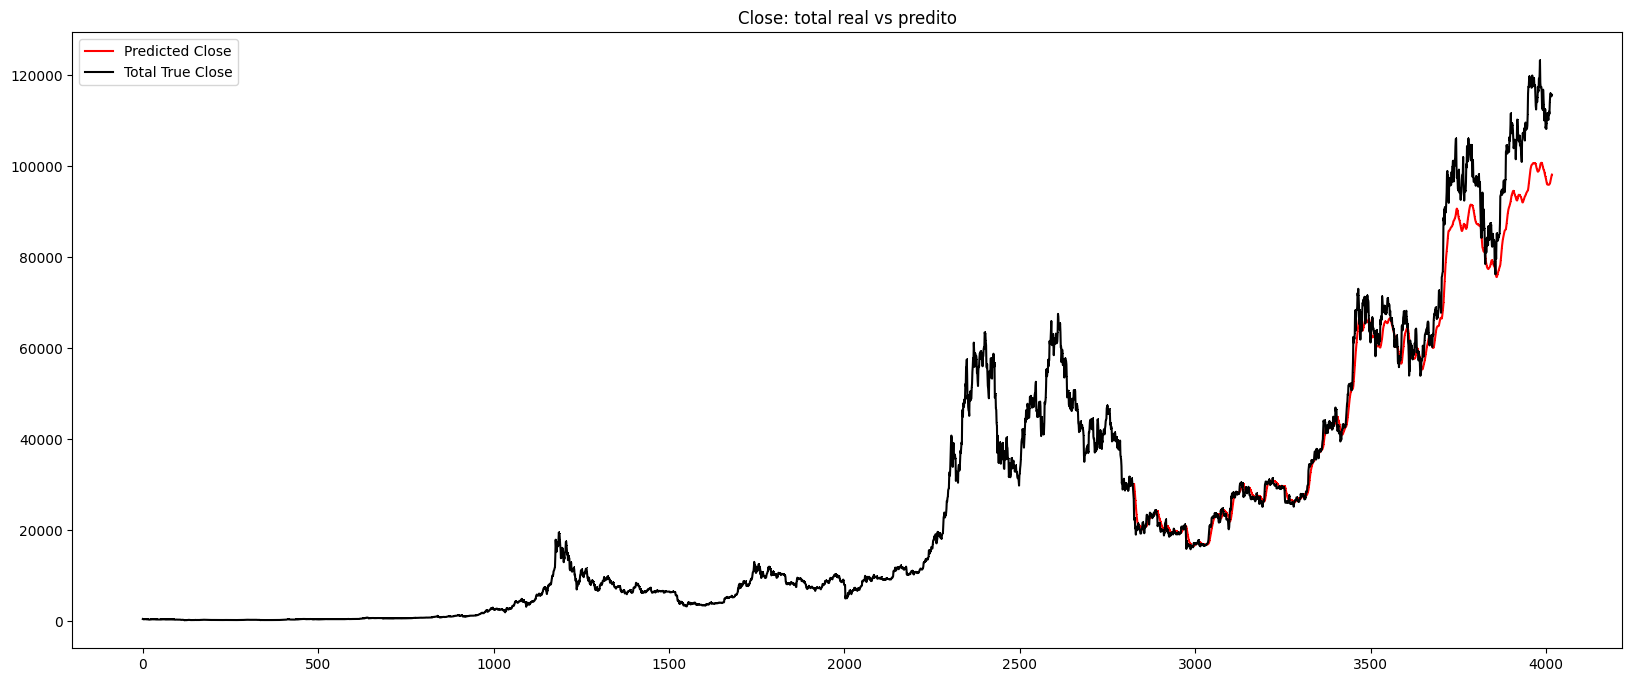

In [278]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

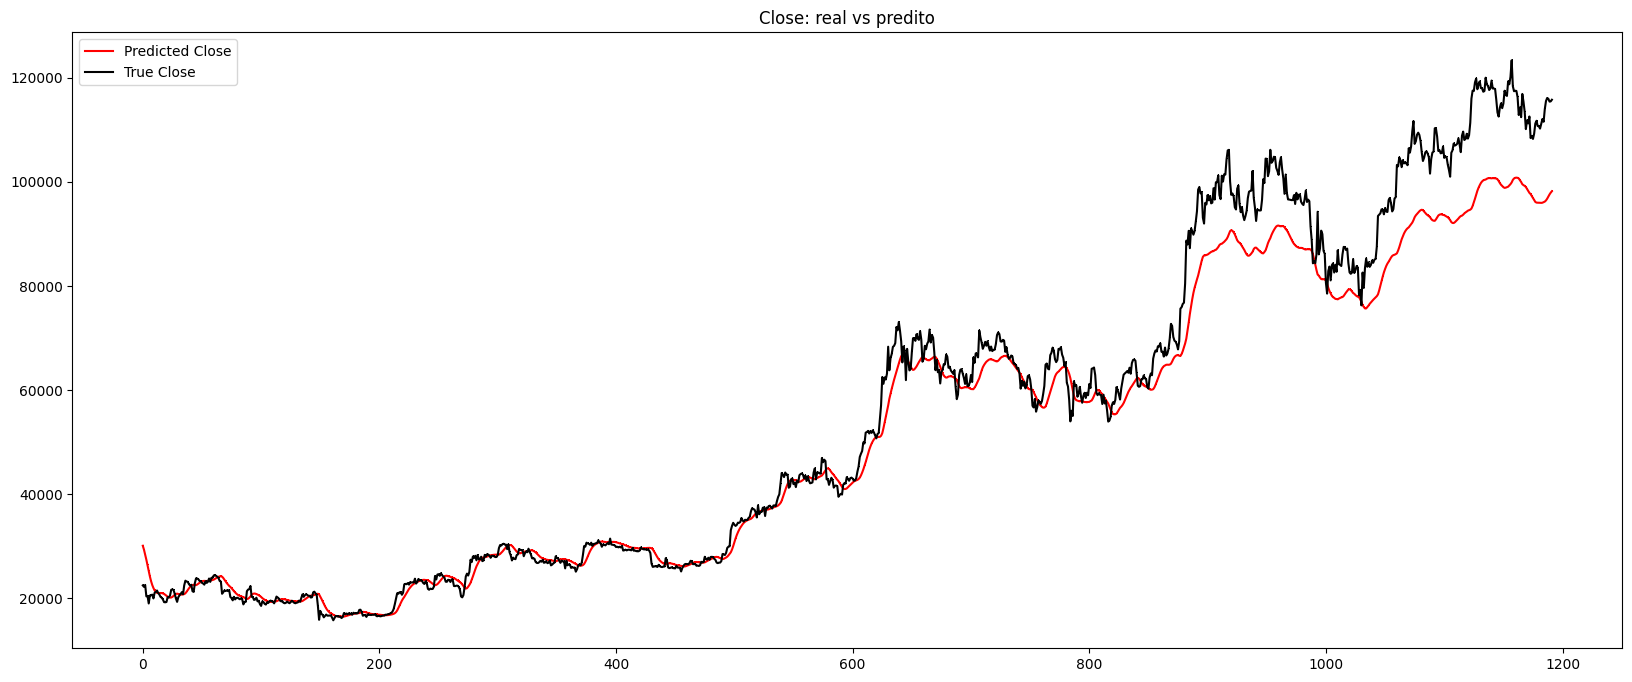

In [279]:
plt.figure(figsize=(20,8))
plt.plot(y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(y_test, color="black", marker=",", label='True Close')
plt.title('Close: real vs predito')
plt.legend()
plt.show()